In [28]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load Spotify song data into a DataFrame
df = pd.read_csv('spotify_songs.csv')

In [4]:
df.head(5)

,title,artist,genres,popularity,danceability,energy,tempo,valence,instrumentalness,acousticness,track_id,artist_id,Primary genre,final genre
0,Jaguar,Yaeger,unknown,34,0.581,0.642,98.030,0.685,0.020000,0.0393,1EbPebzZXIn4QmYsL31Ahy,0sWPIrlMZlHFkDBYkciO3X,unknown,Other
1,Awkward,LOVA,swedish pop,0,0.539,0.466,84.130,0.359,0.000008,0.5910,1DwFRzuCCcU7iogXAieS6V,1l2NYhptmHjo64MDOcej1x,swedish pop,Other
2,Mi Coche,IVAN$ITO,unknown,14,0.877,0.827,91.993,0.770,0.000000,0.4990,3qwHCA1onB4XEJlIyhlD8q,0cPmSFfjpop7imPVWSk2yc,unknown,Other
3,Every Second,Mina Okabe,unknown,56,0.805,0.565,130.016,0.642,0.000002,0.6230,0GxUJLTF4RanPVwY1YpcZ3,5BS8KSKJPeLeXfABQx0bXl,unknown,Other
4,Prom,Augustine,swedish indie pop,26,0.670,0.486,107.988,0.373,0.000363,0.3250,5flMoOfc914PhFtAD8e1gX,1esNGCDFDiy6sKEqPhlLb4,swedish indie pop,Other


In [60]:
genres = df['final genre'].str.get_dummies(sep=',')

In [64]:
genres

,Alternative/Indie,Blues,Country,Electronic/Dance,Folk,Gospel,Hip Hop/Rap,Jazz,Latin,Other,Pop,R&B,Reggae,Rock
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5004,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5005,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5006,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5007,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [22]:
# Select the numerical features to use for clustering
features = ['tempo', 'energy', 'valence','popularity','danceability','instrumentalness', 'acousticness']



In [ ]:
df_features = df[features]

In [66]:
df_features = pd.concat([df_features, genres], axis=1)

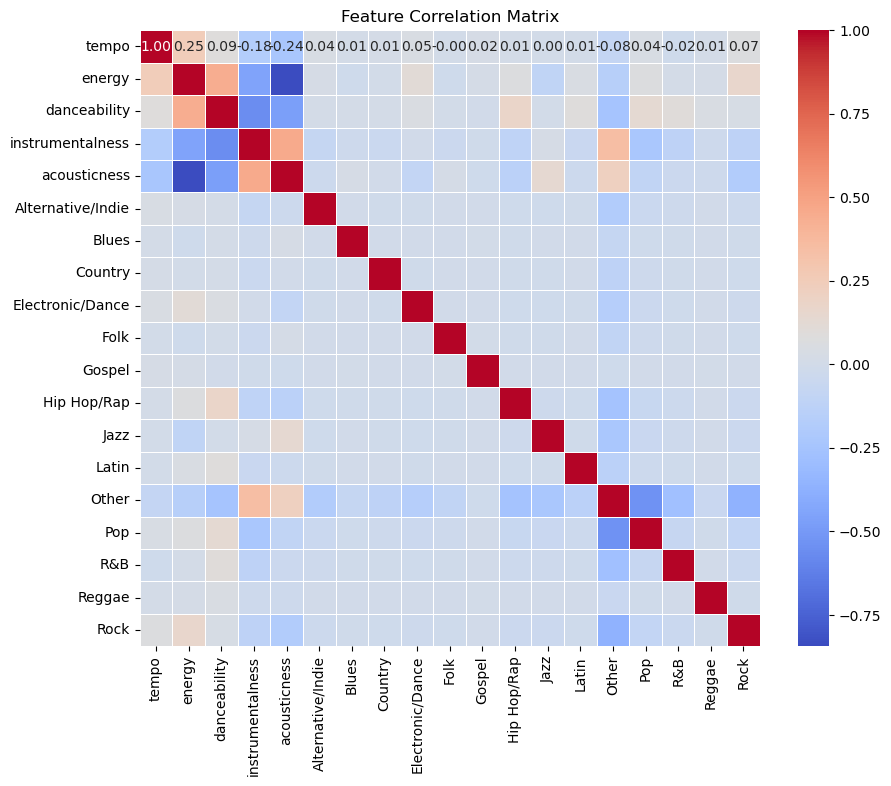

In [70]:

# Calculate the correlation matrix
correlation_matrix = df_features.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


Danceability and valence are highly correlated - I will remove valence. Popularity can also skew results as there is no relation between the songs just because they are both equally popular. Also energy and accousticness are highly correlated.

In [74]:
df_features = df_features.drop(columns=['popularity', 'valence','acousticness','Other'])

KeyError: "['popularity', 'valence'] not found in axis"

In [134]:
df_features = df_features.drop(columns=['Other'])

In [136]:
# Standardize the feature values
scaler = StandardScaler()
X = scaler.fit_transform(df_features)



In [138]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)



/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

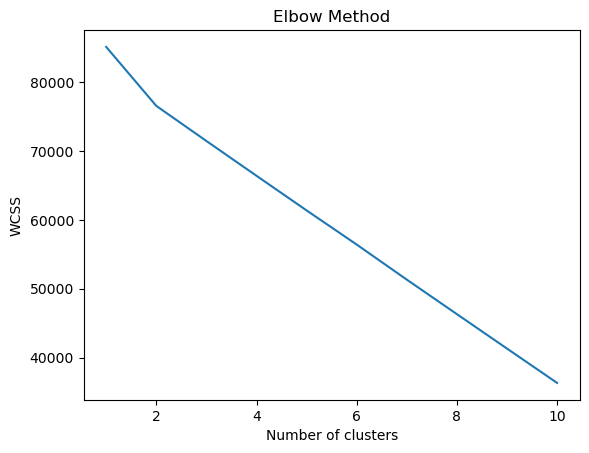

In [140]:
# Plot the elbow curve to find the optimal number of clusters
import matplotlib.pyplot as plt
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



In [142]:
# Perform K-means clustering
num_clusters = 4  
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
labels = kmeans.fit_predict(X)



/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [144]:
# Add the cluster labels back to the original DataFrame
df['cluster'] = labels

In [158]:
# Create the 'popularity_score' column
bins = [0, 25, 50, 75, 100]  # Adjust these thresholds if necessary
labels = ['Low', 'Medium', 'High', 'Highest']

df['popularity_score'] = pd.cut(df['popularity'], bins=bins, labels=labels, right=False)


In [162]:
#Export to csv
df.to_csv('spotify_songs.csv', index=False)

In [171]:
df.head(5)

,title,artist,genres,popularity,danceability,energy,tempo,valence,instrumentalness,acousticness,track_id,artist_id,Primary genre,final genre,cluster,popularity_score
0,Jaguar,Yaeger,unknown,34,0.581,0.642,98.030,0.685,0.020000,0.0393,1EbPebzZXIn4QmYsL31Ahy,0sWPIrlMZlHFkDBYkciO3X,unknown,Other,1,Medium
1,Awkward,LOVA,swedish pop,0,0.539,0.466,84.130,0.359,0.000008,0.5910,1DwFRzuCCcU7iogXAieS6V,1l2NYhptmHjo64MDOcej1x,swedish pop,Other,1,Low
2,Mi Coche,IVAN$ITO,unknown,14,0.877,0.827,91.993,0.770,0.000000,0.4990,3qwHCA1onB4XEJlIyhlD8q,0cPmSFfjpop7imPVWSk2yc,unknown,Other,1,Low
3,Every Second,Mina Okabe,unknown,56,0.805,0.565,130.016,0.642,0.000002,0.6230,0GxUJLTF4RanPVwY1YpcZ3,5BS8KSKJPeLeXfABQx0bXl,unknown,Other,1,High
4,Prom,Augustine,swedish indie pop,26,0.670,0.486,107.988,0.373,0.000363,0.3250,5flMoOfc914PhFtAD8e1gX,1esNGCDFDiy6sKEqPhlLb4,swedish indie pop,Other,1,Medium
